In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
df = pd.read_csv('results.csv')
default = {
    'baud': 38400,
    'tprop': 0,
    'fer': 0,
    'infosize': 512
}
file_size = 10968 * 8

df['tprop'] = df.apply(lambda row: row.tprop/1000000, axis=1)
df['R'] = df.apply(lambda row: file_size/row.time, axis=1)
df['S'] = df.apply(lambda row: row.R/row.baud, axis=1)
df['a'] = df.apply(lambda row: row.tprop/((row.infosize*8/row.baud)), axis=1)

# df.head()

In [3]:
def get_df_with_var(x):
    tmp_df = df
    for i in df.columns.values:
        if i != x and i != 'time':
            tmp_df = tmp_df[tmp_df[i] == default.get(i,tmp_df[i])]
    return tmp_df

def get_group(x):
    foo = get_df_with_var(x)
    foo = foo.groupby([x], as_index=False).mean()
    foo = foo.drop([i for i in default.keys() if i != x] + ['R','time'],1)
    return foo

In [4]:
def plot(x,y,label=None, smoothing=2):
    xnew = np.linspace(x.min(), x.max(), 30) 
    spl = make_interp_spline(x, y, k=smoothing)  # type: BSpline
    y_smooth = spl(xnew)
    
    if label:
        plt.plot(xnew, y_smooth,label=label)
    else:
        plt.plot(xnew, y_smooth)

def plot_param(x, smoothing=2):
    k = get_group(x)
    plot(k[x], k['S'], smoothing=smoothing)
    plt.xlabel(x)
    plt.ylabel('S')
    plt.show()

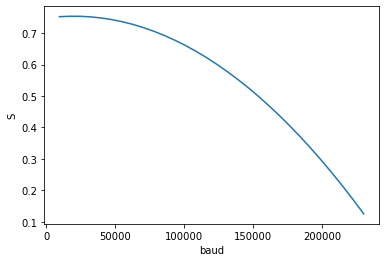

In [5]:
plot_param('baud')

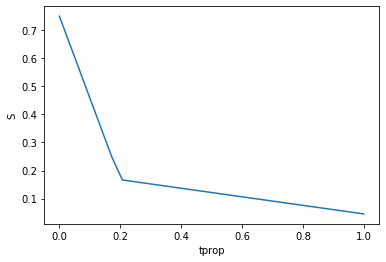

In [6]:
plot_param('tprop', 1)

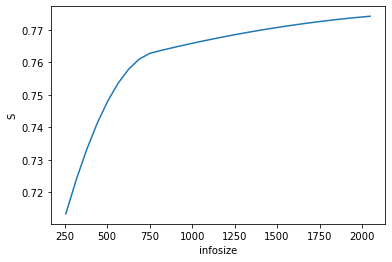

In [7]:
plot_param('infosize')

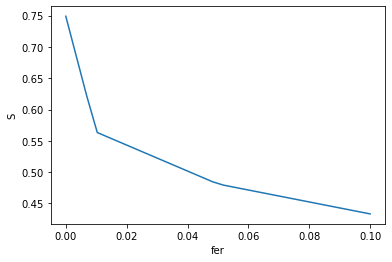

In [8]:
plot_param('fer',1)

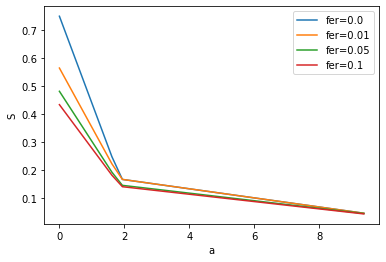

In [9]:
def graph_S_fer_a():
    # Remove fixed values, baud and infosize
    tmp_df = df[df['baud'] == default['baud']]
    tmp_df = tmp_df[tmp_df['infosize'] == default['infosize']]
    tmp_df = tmp_df.drop(['baud', 'infosize'], 1)
    
    for i in [0.00, 0.01, 0.05, 0.10]:
        d = tmp_df[tmp_df['fer'] == i]
        plot(d['a'], d['S'], f'fer={i}', smoothing=1)
    plt.xlabel('a')
    plt.ylabel('S')
    plt.legend()
    plt.show()
graph_S_fer_a()

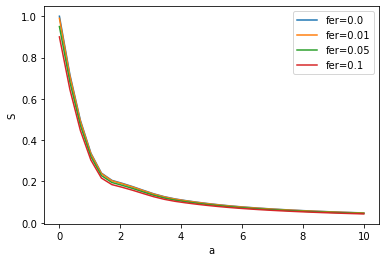

In [10]:
def graph_correct_S_fer_a():
    for i in [0.00, 0.01, 0.05, 0.10]:
        x = np.linspace(0,10,10)
        y = [(1-i)/(1+2*j) for j in x]
        plot(x, y, f'fer={i}')
    plt.xlabel('a')
    plt.ylabel('S')
    plt.legend()
    plt.show()
graph_correct_S_fer_a()

In [11]:
output_df = df.dropna().reset_index(drop=True).round(decimals=5)
output_df.to_csv('output.csv')
